# Assignment

## Importing Libraries

In [711]:
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Datasets

In [712]:
cifar_dataset_train = datasets.CIFAR10(root='./data',train=True,download=True,transform=torchvision.transforms.ToTensor())

cifar_dataset_test = datasets.CIFAR10(root='./data',train=False,download=True,transform=torchvision.transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


## Creating the training dataset

In [884]:
from torch.utils.data import DataLoader
batch_size = 256

train_iter = DataLoader(cifar_dataset_train,batch_size,shuffle=True)

In [885]:
X,y = next(iter(train_iter))

## Creating the test dataset

In [886]:
test_iter = DataLoader(cifar_dataset_test,batch_size,shuffle=True)

In [887]:
X_test,y_test = next(iter(test_iter))

## Analysing the CIFAR-10 data

In [888]:
print(f'The dimensions of each input image is {X.size()} The number of input channels is {X.size()[1]}')
print(f'The output labels are as follows {y}')

The dimensions of each input image is torch.Size([256, 3, 32, 32]) The number of input channels is 3
The output labels are as follows tensor([2, 6, 1, 8, 1, 1, 4, 5, 8, 7, 0, 6, 9, 3, 8, 5, 1, 2, 2, 6, 1, 6, 0, 6,
        3, 3, 2, 1, 6, 4, 8, 5, 9, 0, 9, 9, 1, 1, 1, 6, 7, 7, 7, 7, 7, 1, 8, 8,
        1, 1, 6, 6, 8, 5, 3, 4, 4, 7, 9, 5, 8, 8, 2, 4, 3, 7, 1, 8, 9, 1, 6, 2,
        2, 7, 5, 7, 6, 9, 7, 4, 1, 9, 0, 6, 7, 2, 0, 3, 5, 8, 6, 4, 8, 4, 2, 7,
        3, 1, 1, 0, 5, 5, 0, 2, 3, 8, 6, 8, 4, 8, 6, 0, 8, 3, 7, 1, 2, 5, 4, 4,
        6, 0, 5, 4, 6, 1, 0, 8, 3, 7, 8, 7, 3, 2, 3, 5, 7, 7, 3, 0, 9, 6, 6, 2,
        2, 6, 0, 6, 2, 4, 5, 8, 9, 6, 6, 7, 8, 5, 0, 2, 0, 5, 5, 7, 0, 8, 3, 7,
        1, 0, 2, 2, 3, 2, 2, 7, 6, 7, 7, 7, 8, 4, 1, 9, 6, 1, 8, 6, 4, 3, 6, 7,
        7, 4, 0, 1, 4, 0, 6, 5, 7, 6, 6, 6, 5, 8, 1, 8, 5, 9, 4, 5, 6, 2, 6, 1,
        0, 3, 5, 2, 5, 3, 9, 3, 6, 9, 4, 1, 0, 4, 4, 0, 1, 4, 2, 0, 5, 1, 0, 9,
        7, 2, 2, 8, 6, 1, 5, 4, 6, 1, 5, 8, 1, 1, 6, 6])


## Example image

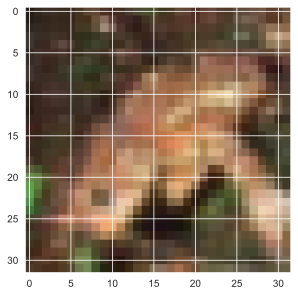

In [889]:
plt.imshow(X[1].T)

## CNN Architecture

In [1181]:
class CNN(torch.nn.Module):
    def __init__(self,num_channels,num_outputs):
        super(CNN,self).__init__()
        self.num_channels = num_channels
        self.num_outputs = num_outputs

        #Spatial/Global Pooling for input-------------------------------------------------------
        self.spatial_avg_pool1 = torch.nn.AdaptiveAvgPool2d((24,24))

        # Design the base block Element---------------------------------------------------------
        #Create an input linear layer for future combination

        self.linear1 = torch.nn.Linear(in_features=1728,out_features=2)
        self.relu1 = torch.nn.ReLU()

        self.conv1 = torch.nn.Conv2d(num_channels,out_channels=18,kernel_size=5,stride=2,padding=1)
        self.relu2 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(num_channels,out_channels=24,kernel_size=5,stride=2,padding=1)
        self.relu3 = torch.nn.ReLU()

        # Create the spatial average pooling layer for the inputs to the dense---------------------
        self.spatial_avg_pool2 = torch.nn.AdaptiveAvgPool1d(1000)

        # Create the dense,classification block----------------------------------------------------
        # First FC linear layer
        self.linear2 = torch.nn.Linear(in_features=1000,out_features=num_outputs)
        self.relu4 = torch.nn.ReLU()

        # Softmax application to get probabilities of classes
        self.softmax = torch.nn.Softmax(dim=1)

        #Initialize the weights and the bias for the linear layer
        # First blocks linear layer
        torch.nn.init.kaiming_normal_(self.linear1.weight,nonlinearity='relu')
        torch.nn.init.zeros_(self.linear1.bias)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)

        #Final linear layer
        torch.nn.init.kaiming_normal_(self.linear2.weight,nonlinearity='relu')
        torch.nn.init.zeros_(self.linear2.bias)

        #Define the proportion of neurons to dropout
        self.dropout = torch.nn.Dropout(0.25)

    def forward(self,x):
        # Applying average pooling to downsample the image from 32 -> 24
        a = self.spatial_avg_pool1(x)

        # First Block------------------------------------------------------
        #Reshape the tensor to allow for matrix multiplication
        a = a.view(a.size(0),-1)

        a = self.linear1(a)
        a = self.dropout(a)
        a = self.relu1(a)

        # Get outputs of each convolution ->RelU layer
        o1 = self.conv1(x)
        o1 = self.relu2(o1)

        o2 = self.conv2(x)
        o2 = self.relu3(o2)
        # --------------------------------------------------------------------

        #Combine the output of each convolutional layer
        O = torch.cat([o1,o2],dim=1)

        O = torch.matmul(a,O.view(2,-1))

        # Apply spatial pooling before entering the dense layer------------
        O_bn = self.spatial_avg_pool2(O)

        # Move to the dense/classification block
        output = self.linear2(O_bn.view(256,-1))
        output = self.dropout(output)
        output = self.relu4(output)

        output = self.softmax(output)

        return output

In [1182]:
model = CNN(num_channels=3,num_outputs=10)
print(model)

CNN(
  (spatial_avg_pool1): AdaptiveAvgPool2d(output_size=(24, 24))
  (linear1): Linear(in_features=1728, out_features=2, bias=True)
  (relu1): ReLU()
  (conv1): Conv2d(3, 18, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (relu2): ReLU()
  (conv2): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (spatial_avg_pool2): AdaptiveAvgPool1d(output_size=1000)
  (linear2): Linear(in_features=1000, out_features=10, bias=True)
  (relu4): ReLU()
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [1183]:
model(X)[0]

tensor([0.1082, 0.0931, 0.0931, 0.1009, 0.0931, 0.0931, 0.1128, 0.1143, 0.0931,
        0.0983], grad_fn=<SelectBackward0>)

## Create the metric for calculating accuracy

In [1184]:
def accuracy(y_hat,y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
        cmp = (y_hat.type(y.dtype) == y)
        return float(torch.sum(cmp))

## Create the model training system

In [1185]:
def train_model(model,X,y,X_test,y_test,accuracy,epochs):

    # Create the loss component
    loss = torch.nn.CrossEntropyLoss()

    # Create the optimizer term
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

    score_train = []
    score_test = []

    for epoch in range(0,epochs,5):
        model.train()
        y_hat = model(X)
        l = loss(y_hat,y)

        optimizer.zero_grad()

        l.backward()
        optimizer.step()

        # Training Accuracy
        score_train.append(accuracy(model(X),y)/len(y))

        # # Test Accuracy
        # torch.no_grad()
        # model.eval()
        # score_test.append(accuracy(model(X_test),y_test)/len(y_test))

    return score_train

In [1186]:
epochs = 100
s1 = train_model(model,X,y,X_test,y_test,accuracy,epochs)

In [1180]:
s1

[0.11328125,
 0.12890625,
 0.13671875,
 0.1328125,
 0.10546875,
 0.10546875,
 0.1328125,
 0.11328125,
 0.09765625,
 0.11328125,
 0.13671875,
 0.09375,
 0.1171875,
 0.09375,
 0.12109375,
 0.1328125,
 0.09765625,
 0.109375,
 0.10546875,
 0.109375]

Text(0, 0.5, 'Accuracy')

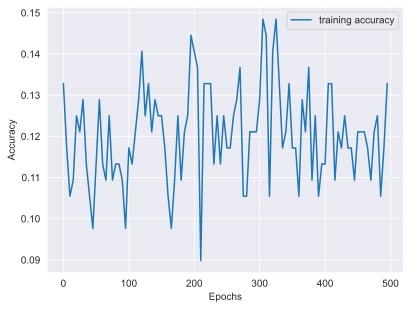

In [1171]:
sns.lineplot(x=range(0,epochs,5),y=s1,label='training accuracy')
#sns.lineplot(x=epochs,y=s2,label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')